# Dynamics Programming Protocol

This tutorial systematically introduces the **Dynamics** programming protocol in BrainState, which defines the standard interface for implementing temporal evolution of neural systems.

## Learning Objectives

You will learn:

- 🧠 **What is Dynamics** - The design philosophy and element-wise computation principle
- ⚙️ **Basic structure** - How to implement the `update()` function
- 🔄 **Before/After updates** - Flexible control flow mechanisms
- 📐 **Size inference** - Input/output dimension management
- ⏱️ **Delay support** - Temporal dynamics with delay mechanisms
- 🌍 **Ecosystem integration** - Usage across brainpy.state, brainmass, and braincell

## Why Dynamics Protocol?

The Dynamics protocol provides:
- 🎯 **Unified interface** - Consistent API across the ecosystem
- 🧩 **Composability** - Easy integration with other modules
- 🔬 **Biological fidelity** - Element-wise dynamics matching neural behavior
- 🚀 **Performance** - Efficient JAX compilation and state management

In [1]:
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt

import brainstate

# Set simulation time step
brainstate.environ.set(dt=0.1 * u.ms)

## Part 1: What is Dynamics?

### Core Concept

`Dynamics` is a module that defines how **state variables evolve over time** in neural or other dynamical systems. All Dynamics models follow the **element-wise computation principle**: state updates only affect local variables and do not include cross-unit interactions.

### Element-Wise Principle

Consider the **Leaky Integrate-and-Fire (LIF)** neuron model:

$$
\tau \frac{dV}{dt} = -(V - V_{rest}) + R I
$$

Each neuron's voltage $V$ evolves **independently** based only on its own state and input current $I$. This is element-wise dynamics.

### What Dynamics is NOT

Dynamics does **NOT** include:
- Synaptic connections between neurons
- Network connectivity
- Inter-neuron interactions

These are handled by separate modules like `Linear`, `Sparse`, or `Convolution` connection operators.

### Architecture Overview

```
Input (External Drive)
    ↓
[Connection Modules]  ← (Linear, Conv, Sparse)
    ↓
[Dynamics Modules]    ← (LIF, HH, Izhikevich)
    ↓
Output (Spikes/Voltages)
```

See [BrainScale documentation](https://brainscale.readthedocs.io) for visual reference.

![](https://brainscale.readthedocs.io/_images/model-dynamics-supported.png)


### Example: Simple Exponential Decay

Let's implement a simple dynamics model that demonstrates the element-wise principle.

In [2]:
class ExponentialDecay(brainstate.nn.Dynamics):
    """Simple exponential decay dynamics: τ dv/dt = -v"""

    def __init__(self, size, tau=10.0 * u.ms):
        super().__init__(in_size=size)

        # State variable
        self.v = brainstate.State(jnp.zeros(size))

        # Parameter (constant, not a State)
        self.tau = tau

    def update(self, inp):
        """Element-wise update: each element evolves independently"""
        # Exponential Euler integration
        dt = brainstate.environ.get_dt()
        alpha = jnp.exp(-dt / self.tau)

        # Update state (element-wise operation)
        self.v.value = self.v.value * alpha + inp

        # Return current state
        return self.v.value


# Create dynamics module with 5 independent elements
dynamics = ExponentialDecay(size=(5,), tau=5.0 * u.ms)

print(f"Dynamics module: {dynamics}")
print(f"Input size:  {dynamics.in_size}")
print(f"Output size: {dynamics.out_size}")
print(f"Variable shape (varshape): {dynamics.varshape}")
print(f"\nInitial state: {dynamics.v.value}")

# Apply input to all 5 elements
inp = jnp.array([1.0, 0.5, 0.0, -0.5, -1.0])
output = dynamics(inp)
print(f"\nAfter one step with input {inp}:")
print(f"Output: {output}")

Dynamics module: ExponentialDecay(
  in_size=(5,),
  out_size=(5,),
  v=State(
    value=ShapedArray(float32[5])
  ),
  tau=5. * msecond
)
Input size:  (5,)
Output size: (5,)
Variable shape (varshape): (5,)

Initial state: [0. 0. 0. 0. 0.]

After one step with input [ 1.   0.5  0.  -0.5 -1. ]:
Output: [ 1.   0.5  0.  -0.5 -1. ]


### Visualizing Element-Wise Dynamics

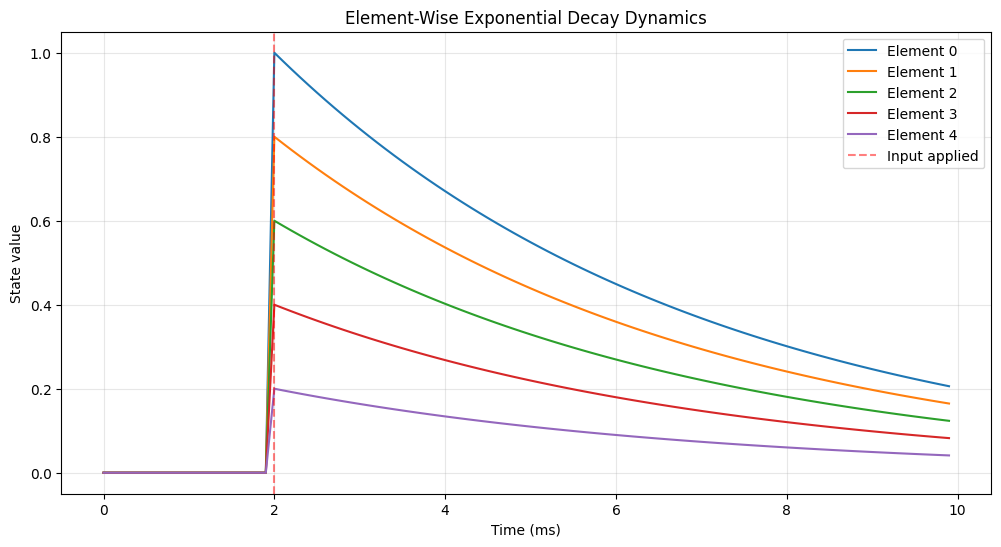

✅ Each element decays independently (element-wise dynamics)
✅ No interaction between elements (pure dynamics, no connectivity)


In [3]:
# Reset dynamics
dynamics.v.value = jnp.zeros(5)

# Simulate with step input
n_steps = 100
history = []

for i in range(n_steps):
    # Step input at t=20ms
    if i == 20:
        inp = jnp.array([1.0, 0.8, 0.6, 0.4, 0.2])
    else:
        inp = jnp.zeros(5)

    output = dynamics(inp)
    history.append(output)

history = jnp.array(history)
times = jnp.arange(n_steps) * brainstate.environ.get_dt()

# Plot
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(times.to_decimal(u.ms), history[:, i], label=f'Element {i}')

plt.axvline(20 * 0.1, color='red', linestyle='--', alpha=0.5, label='Input applied')
plt.xlabel('Time (ms)')
plt.ylabel('State value')
plt.title('Element-Wise Exponential Decay Dynamics')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("✅ Each element decays independently (element-wise dynamics)")
print("✅ No interaction between elements (pure dynamics, no connectivity)")

## Part 2: Basic Dynamics Structure

### The Core: `update()` Function

Every Dynamics module must implement the `update()` method, which defines how state variables evolve in time:

```python
class MyDynamics(brainstate.nn.Dynamics):
    def __init__(self, in_size):
        super().__init__(in_size=in_size)
        # Define state variables with brainstate.State
        self.state_var = brainstate.State(initial_value)
        # Define parameters as regular Python variables (constants)
        self.param = value
    
    def update(self, inp):
        # 1. Compute state evolution
        # 2. Update internal states
        # 3. Return output
        return output
```

### Key Points

- **Input**: External drive (current, synaptic input, etc.)
- **Output**: Observable quantity (voltage, firing rate, spikes, etc.)
- **States**: Dynamic variables that change over time (`brainstate.State`)
- **Parameters**: Constants that don't change during simulation

### Example: Leaky Integrate-and-Fire Neuron

In [4]:
class SimpleLIF(brainstate.nn.Dynamics):
    """Leaky Integrate-and-Fire neuron dynamics.
    
    Equation: τ dV/dt = -(V - V_rest) + R*I
    Spike when V >= V_th, then reset to V_reset
    """

    def __init__(self, size, tau=10.0 * u.ms, V_rest=-65.0 * u.mV,
                 V_th=-50.0 * u.mV, V_reset=-65.0 * u.mV, R=1.0 * u.ohm):
        super().__init__(in_size=size)

        # State variables (dynamic)
        self.V = brainstate.State(jnp.ones(size) * V_rest)
        self.spike = brainstate.State(jnp.zeros(size, dtype=bool))

        # Parameters (constants)
        self.tau = tau
        self.V_rest = V_rest
        self.V_th = V_th
        self.V_reset = V_reset
        self.R = R

    def update(self, I):
        """Update membrane potential and detect spikes.
        
        Args:
            I: Input current
            
        Returns:
            Spike events (boolean array)
        """
        # Exponential Euler integration for V
        dt = brainstate.environ.get_dt()
        alpha = jnp.exp(-dt / self.tau)

        # Update voltage
        V_inf = self.V_rest + self.R * I  # Steady state
        self.V.value = self.V.value * alpha + V_inf * (1 - alpha)

        # Spike detection
        self.spike.value = self.V.value >= self.V_th

        # Reset voltage for spiking neurons
        self.V.value = u.math.where(self.spike.value, self.V_reset, self.V.value)

        return self.spike.value


# Create a population of 3 LIF neurons
lif = SimpleLIF(size=(3,))

print("LIF Neuron Population:")
print(f"  Size: {lif.in_size}")
print(f"  Initial V: {lif.V.value}")
print(f"  Threshold: {lif.V_th}")
print(f"  Time constant: {lif.tau}")

LIF Neuron Population:
  Size: (3,)
  Initial V: ArrayImpl([-65., -65., -65.], dtype=float32) * mvolt
  Threshold: -50.0 * mvolt
  Time constant: 10.0 * msecond


### Simulating the LIF Dynamics

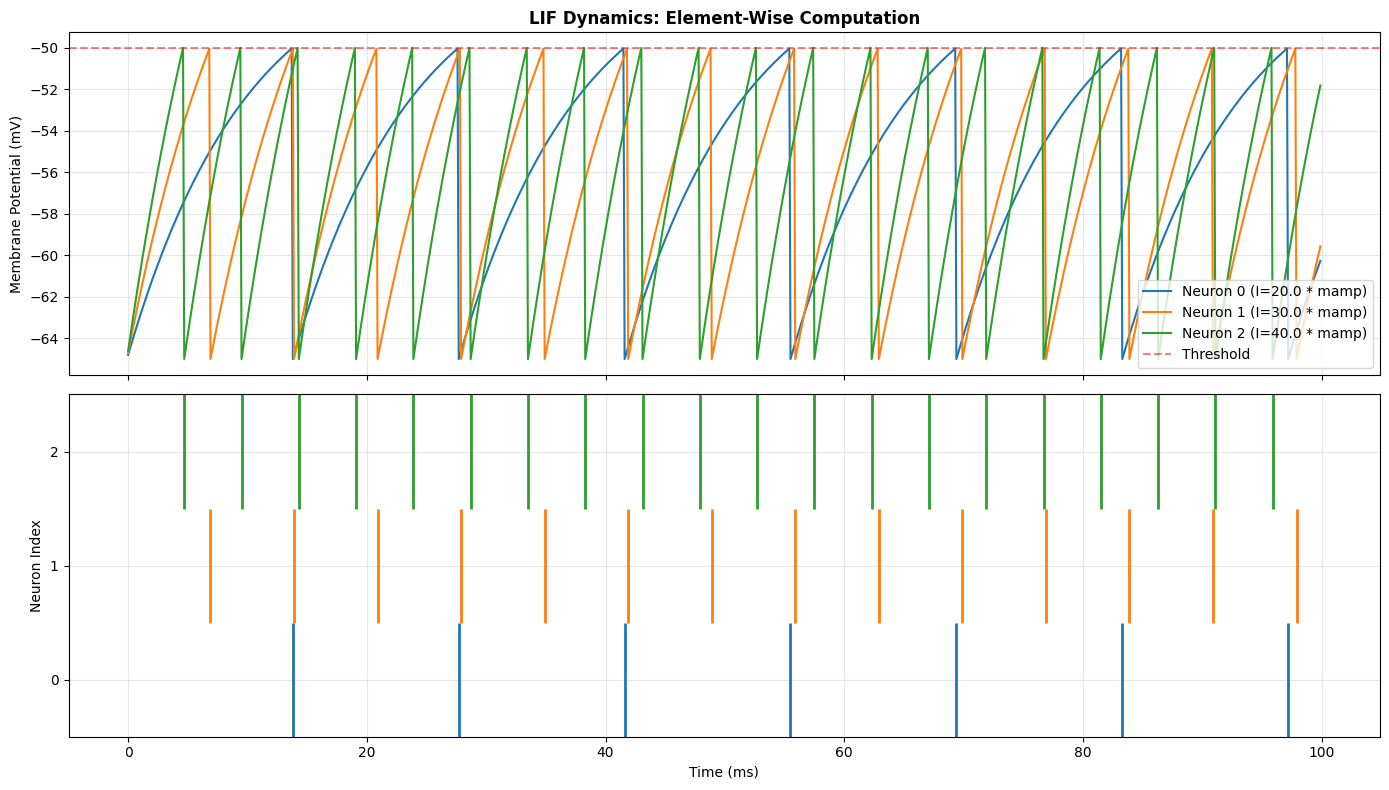

Neuron 0: 7 spikes, rate = 70.00 * becquerel2
Neuron 1: 14 spikes, rate = 140.00 * becquerel2
Neuron 2: 20 spikes, rate = 200.00 * becquerel2

✅ Each neuron evolves independently (element-wise)
✅ Different inputs lead to different firing rates


In [5]:
# Reset neuron states
lif.V.value = jnp.ones(3) * lif.V_rest
lif.spike.value = jnp.zeros(3, dtype=bool)

# Simulation parameters
duration = 100 * u.ms
n_steps = int(duration / brainstate.environ.get_dt())
times = jnp.arange(n_steps) * brainstate.environ.get_dt()

# Different input currents for each neuron
I_inputs = jnp.array([20.0, 30.0, 40.0]) * u.mA


def step_run(t):
    with brainstate.environ.context(t=t):
        spikes = lif(I_inputs)
        return lif.V.value, spikes


# Run simulation
V_history, spike_history = brainstate.transform.for_loop(step_run, times)

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Membrane potentials
for i in range(3):
    axes[0].plot(times.to_decimal(u.ms), V_history[:, i].to_decimal(u.mV),
                 label=f'Neuron {i} (I={I_inputs[i]})', linewidth=1.5)

axes[0].axhline(lif.V_th.to_decimal(u.mV), color='red', linestyle='--',
                alpha=0.5, label='Threshold')
axes[0].set_ylabel('Membrane Potential (mV)')
axes[0].set_title('LIF Dynamics: Element-Wise Computation', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Spike rasters
for i in range(3):
    spike_times = times[spike_history[:, i]]
    if len(spike_times) > 0:
        axes[1].eventplot([spike_times.to_decimal(u.ms)], lineoffsets=[i],
                          colors=[f'C{i}'], linewidths=2)

axes[1].set_ylabel('Neuron Index')
axes[1].set_xlabel('Time (ms)')
axes[1].set_yticks(range(3))
axes[1].set_ylim([-0.5, 2.5])
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
for i in range(3):
    n_spikes = jnp.sum(spike_history[:, i])
    rate = n_spikes / duration * 1000 * u.Hz
    print(f"Neuron {i}: {n_spikes} spikes, rate = {rate:.2f}")

print("\n✅ Each neuron evolves independently (element-wise)")
print("✅ Different inputs lead to different firing rates")

## Part 3: Before/After Update Mechanism

Dynamics supports flexible control flow through **before-update** and **after-update** hooks. These allow you to insert custom logic at specific points in the update cycle.

### Basic Usage

```python
# Add functions to execute before/after update
dynamics.add_before_update(key, function)
dynamics.add_after_update(key, function)
```

### Default Behavior

- **before_update**: Does NOT receive `update()` input parameters
- **after_update**: DOES receive `update()` return value

```python
# Execution flow:
for fn in before_updates:
    fn()  # No parameters

output = dynamics.update(inp)  # Main update

for fn in after_updates:
    fn(output)  # Receives output
```

### Custom Control

You can modify this behavior using decorators:

- `brainstate.nn.receive_update_input(fn)`: Make before_update receive input
- `brainstate.nn.not_receive_update_output(fn)`: Make after_update NOT receive output

### Example: Monitoring with Before/After Updates

In [6]:
class MonitoredLIF(brainstate.nn.Dynamics):
    """LIF with monitoring hooks."""

    def __init__(self, size):
        super().__init__(in_size=size)

        # States
        self.V = brainstate.State(jnp.ones(size) * -65.0 * u.mV)
        self.spike = brainstate.State(jnp.zeros(size, dtype=bool))

        # Monitoring statistics
        self.min_V = brainstate.State(jnp.ones(size) * jnp.inf * u.mV)
        self.max_V = brainstate.State(jnp.ones(size) * -jnp.inf * u.mV)
        self.total_spikes = brainstate.State(jnp.zeros(size, dtype=int))

        # Parameters
        self.tau = 10.0 * u.ms
        self.V_rest = -65.0 * u.mV
        self.V_th = -50.0 * u.mV
        self.V_reset = -65.0 * u.mV

    def update(self, I):
        # Update voltage
        dt = brainstate.environ.get_dt()
        alpha = jnp.exp(-dt / self.tau)
        V_inf = self.V_rest + I * 1.0 * u.ohm
        self.V.value = self.V.value * alpha + V_inf * (1 - alpha)

        # Detect spikes
        self.spike.value = self.V.value >= self.V_th
        self.V.value = u.math.where(self.spike.value, self.V_reset, self.V.value)
        return self.spike.value


# Create neuron
neuron = MonitoredLIF(size=(2,))


# Define monitoring functions
def before_check():
    """Check state before update (no parameters)."""
    print(f"  [Before] V = {neuron.V.value}")


def after_statistics(spikes):
    """Update statistics after update (receives output)."""
    # Update min/max voltage
    neuron.min_V.value = u.math.minimum(neuron.min_V.value, neuron.V.value)
    neuron.max_V.value = u.math.maximum(neuron.max_V.value, neuron.V.value)
    # Count spikes
    neuron.total_spikes.value += spikes


def after_log(spikes):
    """Log output after update (receives output)."""
    if jnp.any(spikes):
        print(f"  [After] Spike detected! Neurons: {jnp.where(spikes)[0]}")


# Add hooks (only for demonstration, normally not called every step)
neuron.add_after_update('statistics', after_statistics)

print("Running simulation with after-update monitoring...\n")

# Simulate for a few steps
for i in range(5):
    print(f"Step {i + 1}:")
    I = jnp.array([3.0, 4.0]) * u.nA
    spikes = neuron(I)
    print(f"  Spikes: {spikes}")
    print(f"  Total spikes so far: {neuron.total_spikes.value}\n")

print("Final statistics:")
print(f"  Min V: {neuron.min_V.value}")
print(f"  Max V: {neuron.max_V.value}")
print(f"  Total spikes: {neuron.total_spikes.value}")

print("\n"
      "✅ After-update hooks receive the output")
print("✅ Useful for monitoring, logging, and statistics")

Running simulation with after-update monitoring...

Step 1:
  Spikes: [False False]
  Total spikes so far: [0 0]

Step 2:
  Spikes: [False False]
  Total spikes so far: [0 0]

Step 3:
  Spikes: [False False]
  Total spikes so far: [0 0]

Step 4:
  Spikes: [False False]
  Total spikes so far: [0 0]

Step 5:
  Spikes: [False False]
  Total spikes so far: [0 0]

Final statistics:
  Min V: ArrayImpl([-65., -65.], dtype=float32) * mvolt
  Max V: ArrayImpl([-65., -65.], dtype=float32) * mvolt
  Total spikes: [0 0]

✅ After-update hooks receive the output
✅ Useful for monitoring, logging, and statistics


### Example: Custom Input/Output Control

In [7]:
# Create a new neuron for this example
neuron2 = MonitoredLIF(size=(1,))


# Before-update that RECEIVES input
@brainstate.nn.receive_update_input
class InputLogger:
    def __call__(self, I):
        print(f"  [Before with input] Received I = {I}")


# After-update that DOES NOT receive output
@brainstate.nn.not_receive_update_output
class StateLogger:
    def __init__(self, neuron):
        self.neuron = neuron

    def __call__(self):
        print(f"  [After without output] Current V = {self.neuron.V.value[0]}")


# Add custom hooks
neuron2.add_before_update('input_log', InputLogger())
neuron2.add_after_update('state_log', StateLogger(neuron2))

print("Running with custom input/output control:\n")
for i in range(3):
    print(f"Step {i + 1}:")
    neuron2(jnp.array([3.5]) * u.nA)
    print()

print("✅ receive_update_input: before-update receives input")
print("✅ not_receive_update_output: after-update doesn't receive output")

Running with custom input/output control:

Step 1:
  [Before with input] Received I = ArrayImpl([3.5], dtype=float32) * namp
  [After without output] Current V = -65.0 * mvolt

Step 2:
  [Before with input] Received I = ArrayImpl([3.5], dtype=float32) * namp
  [After without output] Current V = -65.0 * mvolt

Step 3:
  [Before with input] Received I = ArrayImpl([3.5], dtype=float32) * namp
  [After without output] Current V = -65.0 * mvolt

✅ receive_update_input: before-update receives input
✅ not_receive_update_output: after-update doesn't receive output


## Part 4: Input/Output Size Definition

### Size Management

Dynamics modules use `in_size` to define the geometry of the neuron population:

```python
# 1D population
dynamics = MyDynamics(in_size=10)  # or in_size=(10,)

# 2D population
dynamics = MyDynamics(in_size=(10, 20))

# 3D population
dynamics = MyDynamics(in_size=(10, 20, 5))
```

### Key Attributes

- **`in_size`**: Input shape (tuple)
- **`out_size`**: Output shape (default: same as `in_size`)
- **`varshape`**: Alias for `in_size` (variable shape)

### Size Consistency

This design ensures consistency with the `Module` class and enables seamless integration into larger network architectures.

### Example: Multi-Dimensional Populations

In [8]:
# 1D population (line of neurons)
pop_1d = SimpleLIF(size=10)
print("1D Population:")
print(f"  in_size:  {pop_1d.in_size}")
print(f"  out_size: {pop_1d.out_size}")
print(f"  varshape: {pop_1d.varshape}")
print(f"  V shape:  {pop_1d.V.value.shape}\n")

# 2D population (grid of neurons)
pop_2d = SimpleLIF(size=(8, 8))
print("2D Population (8x8 grid):")
print(f"  in_size:  {pop_2d.in_size}")
print(f"  out_size: {pop_2d.out_size}")
print(f"  varshape: {pop_2d.varshape}")
print(f"  V shape:  {pop_2d.V.value.shape}\n")

# 3D population (volume of neurons)
pop_3d = SimpleLIF(size=(4, 4, 4))
print("3D Population (4x4x4 volume):")
print(f"  in_size:  {pop_3d.in_size}")
print(f"  out_size: {pop_3d.out_size}")
print(f"  varshape: {pop_3d.varshape}")
print(f"  V shape:  {pop_3d.V.value.shape}\n")

# Demonstrate element-wise operation with 2D input
I_2d = brainstate.random.randn(8, 8) * u.nA
spikes_2d = pop_2d(I_2d)

print(f"Applied 2D input with shape {I_2d.shape}")
print(f"Got 2D output with shape {spikes_2d.shape}")
print(f"Number of spikes: {jnp.sum(spikes_2d)}")

print("\n✅ Dynamics supports arbitrary dimensional populations")
print("✅ in_size defines the geometry of the population")
print("✅ Element-wise operations preserve dimensionality")

1D Population:
  in_size:  (10,)
  out_size: (10,)
  varshape: (10,)
  V shape:  (10,)

2D Population (8x8 grid):
  in_size:  (8, 8)
  out_size: (8, 8)
  varshape: (8, 8)
  V shape:  (8, 8)

3D Population (4x4x4 volume):
  in_size:  (4, 4, 4)
  out_size: (4, 4, 4)
  varshape: (4, 4, 4)
  V shape:  (4, 4, 4)

Applied 2D input with shape (8, 8)
Got 2D output with shape (8, 8)
Number of spikes: 0

✅ Dynamics supports arbitrary dimensional populations
✅ in_size defines the geometry of the population
✅ Element-wise operations preserve dimensionality


## Part 5: Delay Support Mechanism

Dynamics naturally supports **temporal delays** through the after-update mechanism, which is crucial for neural dynamics modeling.

### Two Types of Delays

#### 1. Output Delay

Delay the output of `update()` for downstream modules:

```python
# Create delayed output reference
delayed_output = dynamics.output_delay(5.0 * u.ms)

# Access delayed value
value = delayed_output()
```

#### 2. State Delay (Prefetch Delay)

Delay a specific state variable:

```python
# Prefetch delayed state (before init_state is called)
delayed_V = dynamics.prefetch_delay('V', delay_time=5.0 * u.ms)

# Access delayed voltage
v_delayed = delayed_V()
```

### Automatic Synchronization

After each `update()`, the delay buffer is automatically updated through the after-update hook. No manual management required!

### Use Cases

- Axonal delays
- Synaptic delays
- Feedback connections
- Time-delayed systems

### Example: Output Delay

Simulating with output delays...



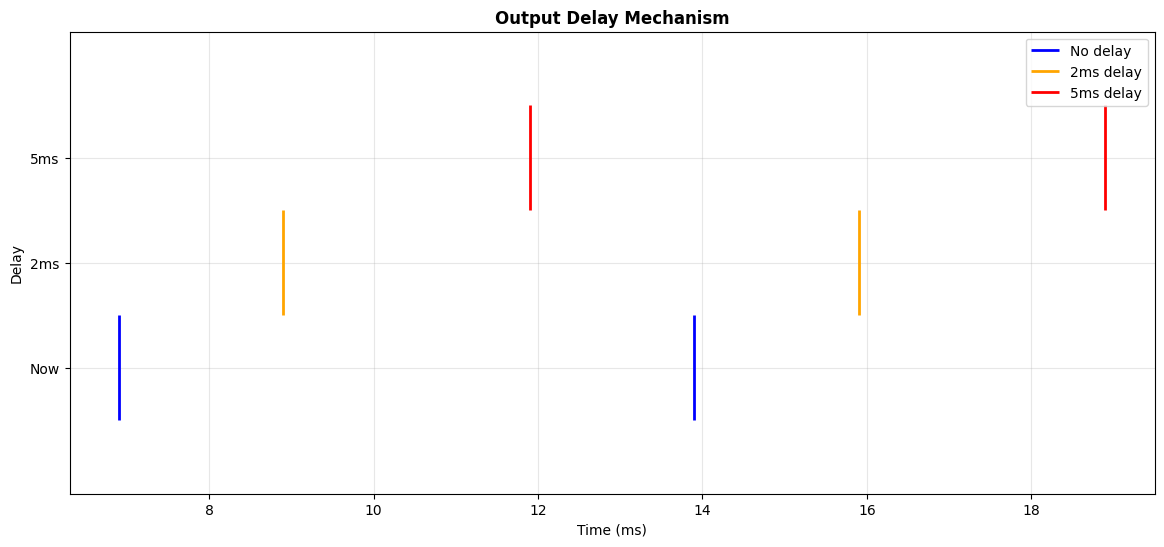

✅ Output delay shifts spikes in time
✅ Multiple delays can coexist
✅ Delays are automatically managed


In [9]:
# Create neuron
neuron = SimpleLIF(size=(1,))

# Create delayed output references
output_now = neuron  # No delay
output_delayed_2ms = neuron.output_delay(2.0 * u.ms)
output_delayed_5ms = neuron.output_delay(5.0 * u.ms)

brainstate.nn.init_all_states(neuron)
print("Simulating with output delays...\n")

# Simulate
n_steps = 200
history_now = []
history_2ms = []
history_5ms = []

for i in range(n_steps):
    t = i * brainstate.environ.get_dt()
    with brainstate.environ.context(t=t, i=i):
        # Update neuron (immediate output)
        spike_now = neuron(30.0 * u.mA)

        # Access delayed outputs
        spike_2ms = output_delayed_2ms()
        spike_5ms = output_delayed_5ms()

        history_now.append(spike_now[0])
        history_2ms.append(spike_2ms[0])
        history_5ms.append(spike_5ms[0])

history_now = jnp.where(jnp.array(history_now))[0]
history_2ms = jnp.where(jnp.array(history_2ms))[0]
history_5ms = jnp.where(jnp.array(history_5ms))[0]
times = jnp.arange(n_steps) * brainstate.environ.get_dt()

# Visualize
plt.figure(figsize=(14, 6))

# Find spike times
spikes_now = times[history_now]
spikes_2ms = times[history_2ms]
spikes_5ms = times[history_5ms]

if len(spikes_now) > 0:
    plt.eventplot(
        [spikes_now.to_decimal(u.ms)],
        lineoffsets=[0],
        colors='blue',
        linewidths=2,
        label='No delay'
    )
if len(spikes_2ms) > 0:
    plt.eventplot(
        [spikes_2ms.to_decimal(u.ms)],
        lineoffsets=[1],
        colors='orange',
        linewidths=2,
        label='2ms delay'
    )
if len(spikes_5ms) > 0:
    plt.eventplot(
        [spikes_5ms.to_decimal(u.ms)],
        lineoffsets=[2],
        colors='red',
        linewidths=2,
        label='5ms delay'
    )

plt.yticks([0, 1, 2], ['Now', '2ms', '5ms'])
plt.xlabel('Time (ms)')
plt.ylabel('Delay')
plt.title('Output Delay Mechanism', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("✅ Output delay shifts spikes in time")
print("✅ Multiple delays can coexist")
print("✅ Delays are automatically managed")

### Example: State Delay (Prefetch Delay)

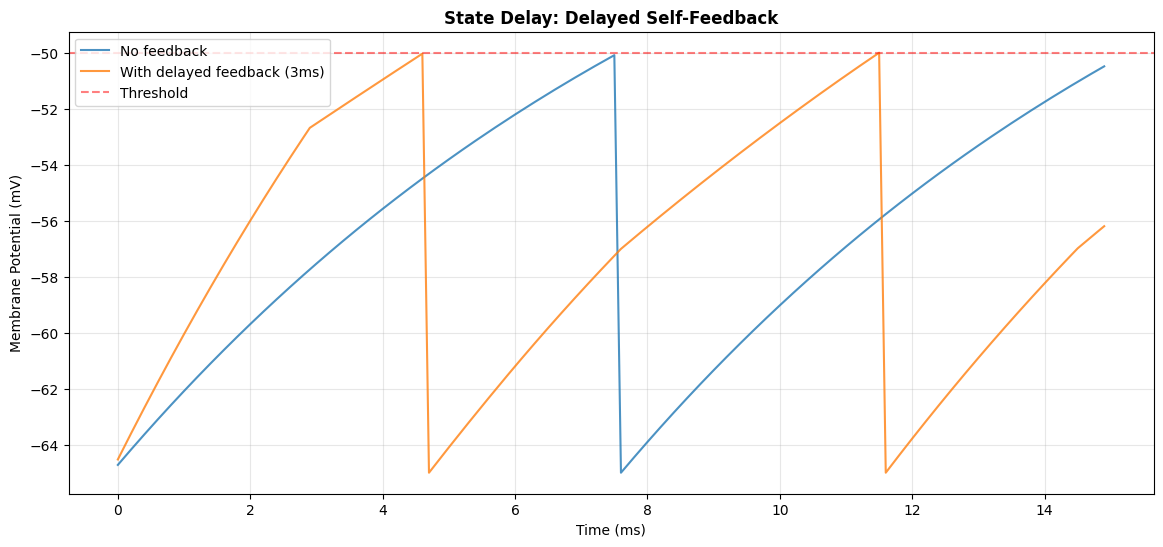

✅ prefetch_delay accesses delayed state variables
✅ Delayed feedback creates oscillatory dynamics
✅ Delay buffer is automatically synchronized after update()


In [10]:
class DelayedFeedbackLIF(brainstate.nn.Dynamics):
    """LIF with delayed self-feedback."""

    def __init__(self, size, feedback_delay=3.0 * u.ms, feedback_strength=0.5):
        super().__init__(in_size=size)

        # Create delayed voltage reference
        self.V_delayed = self.prefetch_delay('V', feedback_delay)

        # Parameters
        self.tau = 10.0 * u.ms
        self.V_rest = -65.0 * u.mV
        self.V_th = -50.0 * u.mV
        self.V_reset = -65.0 * u.mV
        self.feedback_strength = feedback_strength

    def init_state(self, *args, **kwargs):
        self.V = brainstate.State(jnp.ones(self.varshape) * -65.0 * u.mV)
        self.spike = brainstate.State(jnp.zeros(self.varshape, dtype=bool))

    def update(self, I):
        # Get delayed voltage for feedback
        V_delayed = self.V_delayed()

        # Add delayed feedback to input
        feedback_current = (V_delayed - self.V_rest) * self.feedback_strength / (1.0 * u.ohm)
        I_total = I + feedback_current

        # Update voltage
        dt = brainstate.environ.get_dt()
        alpha = jnp.exp(-dt / self.tau)
        V_inf = self.V_rest + I_total * 1.0 * u.ohm
        self.V.value = self.V.value * alpha + V_inf * (1 - alpha)

        # Spike
        self.spike.value = self.V.value >= self.V_th
        self.V.value = u.math.where(self.spike.value, self.V_reset, self.V.value)

        return self.spike.value


# Create neurons: one with feedback, one without
neuron_no_fb = SimpleLIF(size=(1,))
neuron_fb = DelayedFeedbackLIF(size=(1,), feedback_delay=3.0 * u.ms, feedback_strength=0.3)

brainstate.nn.init_all_states(neuron_no_fb)
brainstate.nn.init_all_states(neuron_fb)

# Simulate both
n_steps = 150
V_no_fb = []
V_fb = []

for i in range(n_steps):
    t = i * brainstate.environ.get_dt()
    with brainstate.environ.context(t=t, i=i):
        neuron_no_fb(28.0 * u.mA)
        neuron_fb(28.0 * u.mA)
        V_no_fb.append(neuron_no_fb.V.value[0])
        V_fb.append(neuron_fb.V.value[0])

V_no_fb = u.math.array(V_no_fb)
V_fb = u.math.array(V_fb)
times = jnp.arange(n_steps) * brainstate.environ.get_dt()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(
    times.to_decimal(u.ms),
    V_no_fb.to_decimal(u.mV),
    label='No feedback',
    linewidth=1.5,
    alpha=0.8
)
plt.plot(
    times.to_decimal(u.ms),
    V_fb.to_decimal(u.mV),
    label='With delayed feedback (3ms)',
    linewidth=1.5,
    alpha=0.8
)
plt.axhline(-50, color='red', linestyle='--', alpha=0.5, label='Threshold')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('State Delay: Delayed Self-Feedback', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("✅ prefetch_delay accesses delayed state variables")
print("✅ Delayed feedback creates oscillatory dynamics")
print("✅ Delay buffer is automatically synchronized after update()")

## Part 6: Ecosystem Integration

The Dynamics protocol is the foundation of the BrainPy ecosystem, providing a unified interface across multiple systems:

### **brainpy.state** - General Dynamical Systems

Implements common neuron models (LIF, HH, Izhikevich) and synapse models (Exponential, Alpha, NMDA).

In [11]:
import brainpy

# All follow the Dynamics protocol
lif = brainpy.state.LIF(100)
hh = brainpy.state.ALIF(50)
syn = brainpy.state.Expon(100, tau=5.0)


### **brainmass** - Neural Mass Models

Large-scale brain modeling with population dynamics.

In [12]:
import brainmass
wilson_cowan = brainmass.WilsonCowanModel((10, 10))
jansen_rit = brainmass.JansenRitModel(5)


### **braincell** - Detailed Neuron Models

Multi-compartment neurons with dendritic dynamics.


In [13]:
import braincell
ca = braincell.channel.ICaT_HM1992(10)
na = braincell.ion.Sodium(10)


### Unified Benefits

✅ **Same API** - All use `update()`, before/after updates, delays
✅ **Composable** - Mix and match across systems
✅ **Consistent** - Learn once, use everywhere
✅ **Scalable** - From single neurons to whole brain models

## Summary

### Key Takeaways

#### 1. **Dynamics Concept**
- Defines **element-wise** temporal evolution of state variables
- Does NOT include inter-neuron connectivity
- Foundation for all dynamical systems in the ecosystem

#### 2. **Basic Structure**
- Implement `update(inp)` to define state evolution
- Use `brainstate.State` for dynamic variables
- Use regular Python variables for constants

#### 3. **Before/After Updates**
- `add_before_update(key, fn)` - Execute before `update()`
- `add_after_update(key, fn)` - Execute after `update()`
- Control parameter passing with decorators

#### 4. **Size Management**
- `in_size` defines population geometry
- `out_size` typically matches `in_size`
- `varshape` is an alias for `in_size`

#### 5. **Delay Support**
- `output_delay(time)` - Delay the output
- `prefetch_delay(state, time)` - Delay a specific state
- Automatic synchronization through after-updates

#### 6. **Ecosystem Integration**
- Unified interface across brainpy.state, brainmass, braincell
- Composable and interoperable
- Learn once, use everywhere

### Best Practices

✅ **Always call `super().__init__(in_size=size)`** in `__init__`  
✅ **Use `brainstate.State` for variables that change** during simulation  
✅ **Use regular variables for constants** (parameters, time constants)  
✅ **Return meaningful outputs** from `update()` (spikes, voltages, etc.)  
✅ **Use delays through the protocol** rather than manual buffering  
✅ **Leverage before/after updates** for monitoring and statistics

### Protocol Summary

```python
class MyDynamics(brainstate.nn.Dynamics):
    def __init__(self, in_size, **params):
        super().__init__(in_size=in_size)
        
        # States (dynamic variables)
        self.state = brainstate.State(initial_value)
        
        # Parameters (constants)
        self.param = value
        
        # Optional: prefetch delays
        self.state_delayed = self.prefetch_delay('state', delay_time)
        
    def update(self, inp):
        # 1. Compute new state values
        # 2. Update self.state.value
        # 3. Return output
        return output
```

## Exercise: Implement Your Own Dynamics

### Task

Implement a simplified **Izhikevich neuron** model:

$$
\frac{dv}{dt} = 0.04v^2 + 5v + 140 - u + I
$$
$$
\frac{du}{dt} = a(bv - u)
$$

When $v \geq 30$: spike, then $v \leftarrow c$, $u \leftarrow u + d$

### Requirements

1. Inherit from `brainstate.nn.Dynamics`
2. Define states `v` and `u`
3. Define parameters `a`, `b`, `c`, `d`
4. Implement `update(I)` with Euler integration
5. Return spike events

### Starter Code

In [14]:
class Izhikevich(brainstate.nn.Dynamics):
    """Izhikevich neuron model."""

    def __init__(self, size, a=0.02, b=0.2, c=-65.0, d=8.0):
        # TODO: Initialize parent class
        # TODO: Create states v and u
        # TODO: Store parameters a, b, c, d
        pass

    def update(self, I):
        # TODO: Implement Euler integration
        # TODO: Detect spikes (v >= 30)
        # TODO: Reset v and u when spike occurs
        # TODO: Return spike events
        pass

# Test your implementation
# izh = Izhikevich(size=1)
# for i in range(100):
#     spike = izh(jnp.array([10.0]))
#     if spike[0]:
#         print(f"Spike at step {i}")

### Solution Hints

<details>
<summary>Click to show hints</summary>

1. **Initialization**:
   ```python
   super().__init__(in_size=size)
   self.v = brainstate.State(jnp.ones(size) * -65.0)
   self.u = brainstate.State(jnp.ones(size) * b * -65.0)
   ```

2. **Euler integration**:
   ```python
   dt = brainstate.environ.get_dt().to_decimal(u.ms)
   dv = (0.04 * v**2 + 5*v + 140 - u + I) * dt
   du = a * (b*v - u) * dt
   ```

3. **Spike detection and reset**:
   ```python
   spike = v >= 30
   v = jnp.where(spike, c, v)
   u = jnp.where(spike, u + d, u)
   ```

</details>

### Further Exploration

- Add delayed self-feedback using `prefetch_delay`
- Add monitoring using before/after updates
- Implement different Izhikevich neuron types (RS, IB, CH, FS)
- Combine with synaptic models from brainpy.state

## Additional Resources

### Documentation
- [BrainState API Reference](https://brainstate.readthedocs.io/)
- [BrainPy Documentation](https://brainpy.readthedocs.io/)
- [BrainScale Documentation](https://brainscale.readthedocs.io/)

### Related Tutorials
- `06_delay_basics.ipynb` - Detailed delay mechanisms
- `01_module_basics.ipynb` - Module system fundamentals
- `02_state_management.ipynb` - State management in depth

### Papers
- Izhikevich, E. M. (2003). Simple model of spiking neurons. IEEE Transactions on neural networks.
- Brette, R., & Gerstner, W. (2005). Adaptive exponential integrate-and-fire model.
- Gerstner, W., et al. (2014). Neuronal Dynamics: From Single Neurons to Networks and Models of Cognition.